# 01. Exploring the impact of cyclones on vegetation: scene before and after cyclone

metadata blah

In [1]:
%pylab notebook
from __future__ import print_function
import datacube
import pandas as pd
import xarray as xr
from datetime import date, timedelta
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube_stats.statistics import GeoMedian
import gdal
from gdal import *

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [21]:
###User input: enter the directory location of input data.
input_folder = '/g/data/w85/ext547/input_data/'

###User input : enter the directory location of output data. Please enter again if the same as input_folder.
output_folder = '/g/data/w85/ext547/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [23]:
###User input: enter area of interest
lat_min = -20.385 #down
lat_max = -20.326 #up
lon_min = 148.916 #left
lon_max = 148.984 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input:enter the name of cyclone
cyclone_name =  'Yasi'

# Datacube query is completed

In [26]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range

#Define temporal range
start_of_epoch = '2000-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2017-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = [
    'ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to present, full contintal coverage from 1987 onwards
        ] 


query = {
    'time': (start_of_epoch, end_of_epoch),
}
   
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2017-12-31'), 'x': (148.916, 148.984), 'y': (-20.326, -20.385), 'crs': 'EPSG:4326'}


In [27]:
#Create cloud and land/sea mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea': 'land'}

# Complete Datacube extraction

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the sea are converted to "nan" values with the 'land_sea' command.

In [28]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_free_threshold = 0.80  ###User modification: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [29]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 58, x: 315, y: 299)
 Coordinates:
   * time     (time) datetime64[ns] 2003-07-17T23:41:17.500000 ...
   * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
   * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
 Data variables:
     green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 147, x: 315, y: 299)
 Coordinates:
   * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
   * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
   * x        (x) float64 1.7

In [30]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [31]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 251, x: 315, y: 299)
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
  * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
Data variables:
    green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1751300.00|\n| 0.00,-25.00,-2296525.00|\n| 0.00,...

In [32]:
product_time = nbar_clean[['time', 'product']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [33]:
start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime

event_dates=pd.DataFrame()
delta = end_of_event - start_of_event
for i in range(delta.days + 1):
    date=start_of_event + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    event_dates=event_dates.append(date)
event_dates.columns=['date']
event_dates=event_dates.set_index('date',drop=False)
event_dates.index=event_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
event_dates['test']=1

In [37]:
start_of_interest= start_of_event+datetime.timedelta(days=-200)
end_of_interest= end_of_event+datetime.timedelta(days=200)

interest_dates=pd.DataFrame()
delta = end_of_interest - start_of_interest
for i in range(delta.days + 1):
    date=start_of_interest + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    interest_dates=interest_dates.append(date)

interest_dates.columns=['date']
interest_dates=interest_dates.set_index('date',drop=False)
interest_dates.index=interest_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
interest_dates['test']=1

In [38]:
subset_data = pd.merge(interest_dates, product_time, left_index=True,#left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

# Create an interactive graph that shows suitable imagery before and after the cyclone

<IPython.core.display.Javascript object>


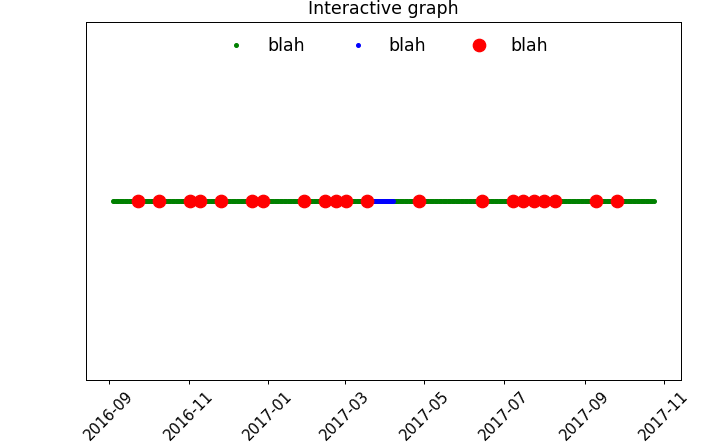

HTML(value='Event information appears here when you click on the figure')

In [39]:
#create widget that enables interaction with hydrograph
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int, devent
    devent = event
    date_int = event.xdata
#     discharge_int= event.ydata
    time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(8,5)) #Edit size of plot ##User should format as required
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph', size=14) #Plot title ##User should format if required
plt.show() #Plot setup
display(w) #Plot setup
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99) #Make border white ##User should format if required

#
matplotlib.pyplot.plot_date(interest_dates.date,interest_dates.test, 'g.', 
                            label= 'blah') #plot all discharge values ##User should format series if required
matplotlib.pyplot.plot_date(event_dates.date,event_dates.test, 'b.', 
                            label= 'blah') #plot all discharge values ##User should format series if required
matplotlib.pyplot.plot_date(subset_data.date,subset_data.test, 'r.', markersize=20,
                            label= 'blah') #plot all discharge values ##User should format series if required


#Axis details
# firstyear =  min_date ###User modification: set period of interest use "min_date" variable for automatic scaling
# lastyear = max_date ###User modification: set period of interest use "max_date" variable for automatic scaling
# plt.axis([firstyear , lastyear ,min_flow, max_flow], 'tight') #Set axis
plt.yticks([]) #format size of date labels ##User should format if required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels ##User should format if required
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot ##User should format if required


In [43]:
date_int
time_slice = matplotlib.dates.num2date(date_int).date()
time_slice=format(time_slice,'%Y-%m-%d %H:%M:%S')
time_slice= str(time_slice) #Convert to string
time_slice=datetime.datetime.strptime(time_slice,'%Y-%m-%d  %H:%M:%S') #Convert to datetime
time_slice

datetime.datetime(2017, 3, 2, 0, 0)

In [44]:
#Prepare imagery
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


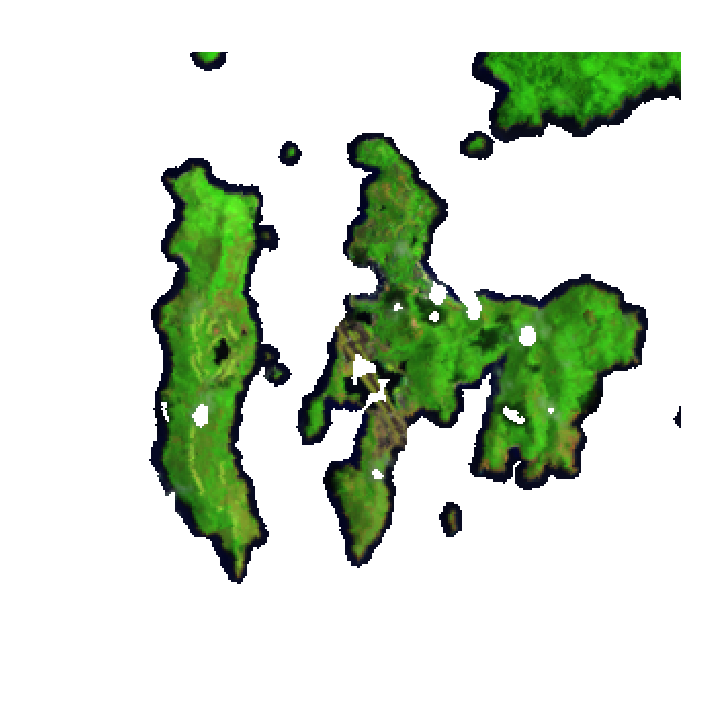

In [45]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required

#Edit plot title ##User should format as required
# plt.title('Gauge: '+gauge_of_interest +'   Date: '+str(time_slice_actual)[0:-9]  + 
#           '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
#           '   Percentage exceedance: '+ str(perexc_title2) + '%', size=10) 

#Add marker to show location of stream gauge 
# plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=150)
plt.imshow(scaled, interpolation = 'nearest')
#            extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
#                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

In [46]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi_of_interest= ndvi.sel(time = time_slice, method='nearest')
ndvi_of_interest

<xarray.DataArray (y: 299, x: 315)>
array([[      nan,       nan,       nan, ...,  0.904803,  0.901035,  0.903641],
       [      nan,       nan,       nan, ...,  0.902176,  0.898259,  0.899826],
       [      nan,       nan,       nan, ...,  0.905688,  0.896213,  0.894343],
       ..., 
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
    time     datetime64[ns] 2017-03-02T00:04:41

<IPython.core.display.Javascript object>


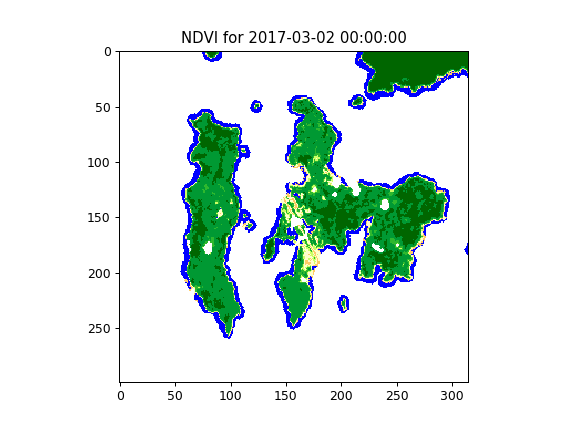

In [47]:
#This controls the colour maps used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

fig = plt.figure()
plt.title('NDVI for '+str(time_slice))
plt.imshow(ndvi_of_interest,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm)

<IPython.core.display.Javascript object>


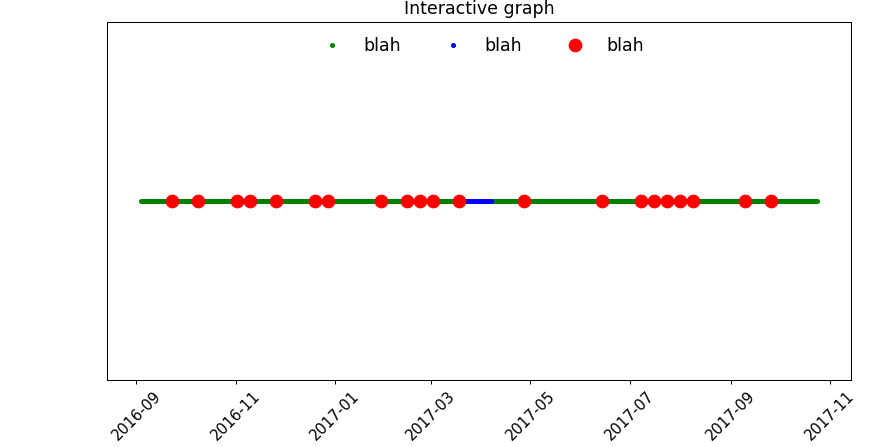

HTML(value='Event information appears here when you click on the figure')

In [48]:
#create widget that enables interaction with hydrograph
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int2, devent
    devent = event
    date_int2 = event.xdata
#     discharge_int= event.ydata
    date_int_ = date_int2.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(10,5)) #Edit size of plot ##User should format as required
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph', size=14) #Plot title ##User should format if required
plt.show() #Plot setup
display(w) #Plot setup
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99) #Make border white ##User should format if required

matplotlib.pyplot.plot_date(interest_dates.date,interest_dates.test, 'g.', 
                            label= 'blah') #plot all discharge values ##User should format series if required
matplotlib.pyplot.plot_date(event_dates.date,event_dates.test, 'b.', 
                            label= 'blah') #plot all discharge values ##User should format series if required
matplotlib.pyplot.plot_date(subset_data.date,subset_data.test, 'r.', markersize=20,
                            label= 'blah') #plot all discharge values ##User should format series if required


#Axis details
# firstyear =  min_date ###User modification: set period of interest use "min_date" variable for automatic scaling
# lastyear = max_date ###User modification: set period of interest use "max_date" variable for automatic scaling
# plt.axis([firstyear , lastyear ,min_flow, max_flow], 'tight') #Set axis
plt.yticks([]) #format size of date labels ##User should format if required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels ##User should format if required
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot ##User should format if required

In [73]:
time_slice2 = matplotlib.dates.num2date(date_int2).date()
time_slice2=format(time_slice2,'%Y-%m-%d %H:%M:%S')
time_slice2= str(time_slice2) #Convert to string
time_slice2=datetime.datetime.strptime(time_slice2,'%Y-%m-%d  %H:%M:%S') #Convert to datetime
time_slice2

datetime.datetime(2017, 6, 12, 0, 0)

In [74]:
#Prepare imagery
rgb2 = nbar_clean.sel(time =time_slice2, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb2 = rgb2.astype('double')
clipped_visible2 = rgb2.where(rgb2<fake_saturation).fillna(fake_saturation)
max_val2 = clipped_visible2.max(['y', 'x'])
scaled2 = (clipped_visible2 / max_val2)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


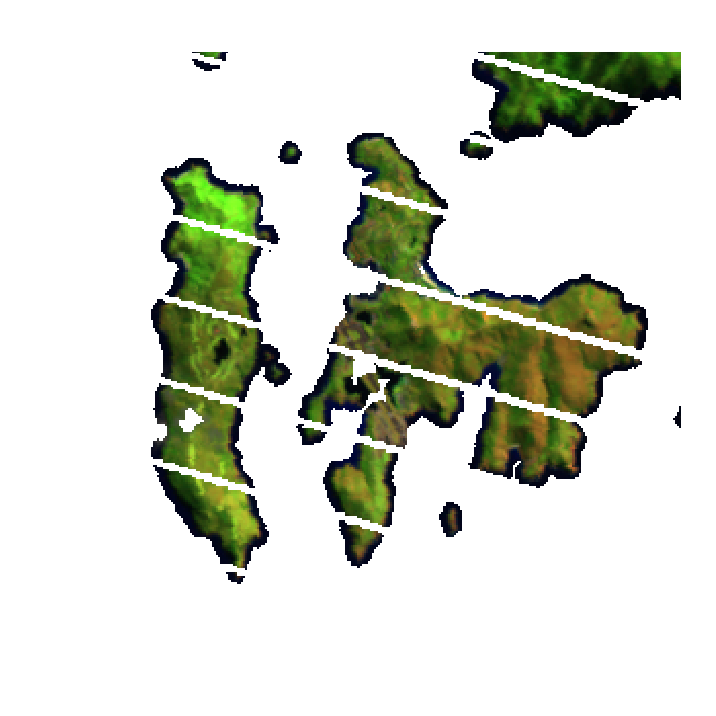

In [75]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required

plt.imshow(scaled2, interpolation = 'nearest')

plt.show() #Create plot

In [53]:
ndvi_of_interest2= ndvi.sel(time = time_slice2, method='nearest')
ndvi_of_interest2

<xarray.DataArray (y: 299, x: 315)>
array([[      nan,       nan,       nan, ...,  0.608438,  0.604264,  0.557012],
       [      nan,       nan,       nan, ...,  0.58947 ,  0.597904,  0.6     ],
       [      nan,       nan,       nan, ...,  0.59342 ,  0.576737,  0.584855],
       ..., 
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
    time     datetime64[ns] 2017-04-27T00:07:15.500000
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1751300.00|\n| 0.00,-25.00,-2296525.00|\n| 0.00,...

<IPython.core.display.Javascript object>


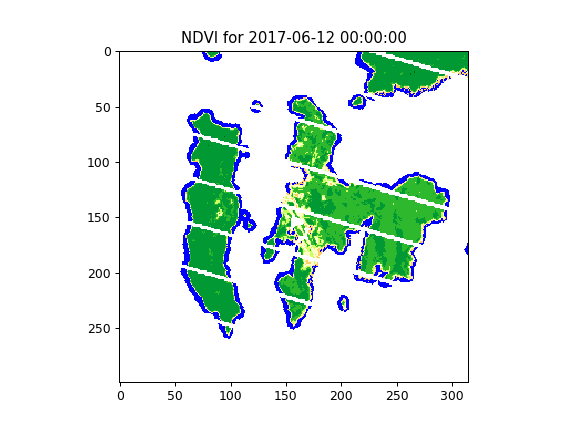

In [76]:
fig = plt.figure()
plt.title('NDVI for '+str(time_slice2))
plt.imshow(ndvi_of_interest2,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm)

In [62]:
ndvi_change= ndvi_of_interest2-ndvi_of_interest
ndvi_change.attrs['affine'] = affine

<IPython.core.display.Javascript object>


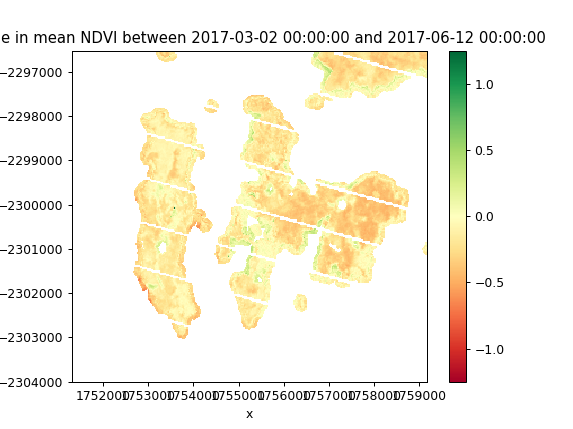

In [77]:
fig = plt.figure()

ndvi_change.plot(cmap = 'RdYlGn')
plt.title('Change in mean NDVI between '+str(time_slice)+' and '+str(time_slice2))
plt.show()

# Import and process windfield data to ensure pixel size and projection is the same as NDVI dataset

In [78]:
#read windfield geotiff
windfield = gdal.Open(input_folder+'Final_corrected_TCDebbie_wind.tif', gdal.GA_ReadOnly)
windfield

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc283223090> >

In [79]:
#get projection information from windfiled
windfield_proj = windfield.GetProjection()
windfield_proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [80]:
ndvi_change

<xarray.DataArray (y: 299, x: 315)>
array([[      nan,       nan,       nan, ..., -0.296365, -0.296771, -0.346629],
       [      nan,       nan,       nan, ..., -0.312706, -0.300355, -0.299826],
       [      nan,       nan,       nan, ..., -0.312267, -0.319477, -0.309488],
       ..., 
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
Attributes:
    affine:   | 25.00, 0.00, 1751300.00|\n| 0.00,-25.00,-2296525.00|\n| 0.00,...

In [81]:
#Convert NDVI data array to raster saved in memory

#save NDVI_change dataset to a numpy array
ndvi_array = np.asarray(ndvi_change)

#define conversion variables
cols= int(ndvi_change.x.count())
rows= int(ndvi_change.y.count())
originX= ndvi_change.affine.c
dx= ndvi_change.affine.a
originY= ndvi_change.affine.f
dy= ndvi_change.affine.e
epsg=int((str(crs)).replace('EPSG:',''))
nodata=0

#complete conversion of NDVI array into raster
driver = gdal.GetDriverByName('MEM')
ndvi_raster = driver.Create('ndvi', cols, rows, 1, gdal.GDT_Float32)
ndvi_raster.SetGeoTransform((originX, dx, 0, originY, 0, dy))
ndvi_band = ndvi_raster.GetRasterBand(1)
ndvi_band.WriteArray(ndvi_array)
ndvi_band.SetNoDataValue(nodata)
ndvi_raster_SRS = osr.SpatialReference()
ndvi_raster_SRS.ImportFromEPSG(epsg)
ndvi_raster.SetProjection(ndvi_raster_SRS.ExportToWkt())
ndvi_band.FlushCache()

In [82]:
#Save metadata from NDVI_change
match_ds = ndvi_raster
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

In [83]:
#Create a  geotiff that is the same size and is in the same projection as the NDVI dataset
drv = gdal.GetDriverByName('GTiff')
windfield_matched = drv.Create('ouput_file', wide, high, 1, gdal.GDT_Float32)
windfield_matched.SetGeoTransform(match_geotrans)
windfield_matched.SetProjection(match_proj)

#create windfield geotiff
resampling_method = gdalconst.GRA_Bilinear
gdal.ReprojectImage(windfield, windfield_matched, windfield_proj, match_proj, resampling_method)

#view datasets and projections to ensure information looks correct
print ('windfield       = ', windfield)
print ('windfield_matched             = ',windfield_matched)
print ('windfield_proj        = ',windfield_proj)
print ('match_proj      = ',match_proj)

windfield       =  <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc283223090> >
windfield_matched             =  <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc287467600> >
windfield_proj        =  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
match_proj      =  PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_

# Save resampled windfield as an array and check array shape

In [84]:
windfield_matched_array=windfield_matched.ReadAsArray()

print('windfield shape = '+ str(shape(windfield_matched_array)))
print('ndvi_change shape = '+ str(shape(ndvi_change.values)))

windfield shape = (299, 315)
ndvi_change shape = (299, 315)


# Create a plot that examines relationship between wind and change in NDVI after a cyclone

<IPython.core.display.Javascript object>


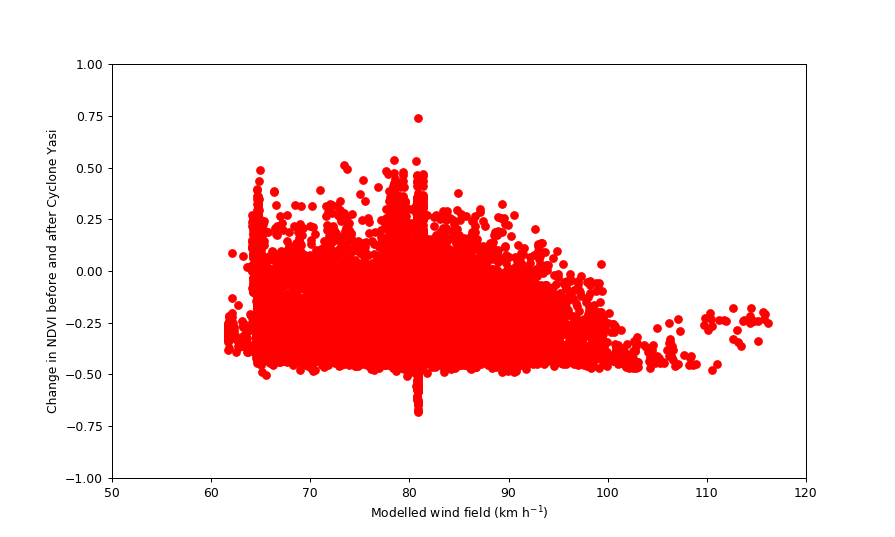

In [85]:
fig = plt.figure(figsize=(10,6))
plt.plot(windfield_matched_array, ndvi_change.values, 'ro') 
plt.axis([50 , 120 ,-1.0, 1.0], 'tight')
plt.xlabel('Modelled wind field (km h$^{-1}$)') #Set X label
plt.ylabel('Change in NDVI before and after Cyclone '+str(cyclone_name)) #Set Y label

plt.show()